MNS 4
===
Dominik Krzemiński

In [145]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import pdb

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### 1. Synaptic current
a)

In [146]:
def euler(f_func, x_0, t_max, dt, **params):
    t = np.arange(0, t_max, dt)
    n = len(t)
    x = np.zeros((n,1))
    x[0] = x_0
    for i in range(1, n):
        x[i] = x[i-1] + f_func(x[i-1], t[i-1], **params)*dt
    return x

In [147]:
def g_syn(t, tau_syn=10*1e-3, g_max=50*1e-9):
    gvec = np.zeros(len(t))
    idcs = np.where(t>=0)[0]
    gvec[idcs] = (g_max*t[idcs]/tau_syn)*np.exp(-t[idcs]/tau_syn)
    return gvec


In [148]:
###################### defining constants
tau = 10*1e-3 #s
Em = -80*1e-3 # V
Rm = 10**7 # Ohm
Ie = 0
Esyn = -100*1e-3 #V
Eexc = 0
Einh = -100*1e-3 #V
#######################

tv = np.linspace(-0.1,0.4,200) #m

def voltage(v, t, Is, Ie=0):
    return (-v + Em - Rm*Is + Rm*Ie)/tau


In [149]:
def synaptic_values(Esyn, tv, shunting=0):
    dt = tv[-1]-tv[-2]
    gsyn = g_syn(tv, tau)
    v = np.zeros(len(tv))
    im = np.zeros(len(tv))
    isyn = np.zeros(len(tv))
    v[0] = Em
    for i in range(1, len(tv)):
        if shunting==0:
            isyn[i] = gsyn[i-1]*(v[i-1]-Esyn)
        elif shunting==1:
            isyn[i] = g_exc*(v[i-1]-Eexc) + g_inh*(v[i-1]-Einh)
        elif shunting==2:
            isyn[i] = gsyn[i-1]*(v[i-1]-Esyn) + g_exc*(v[i-1]-Eexc) + g_inh*(v[i-1]-Einh)
        v[i]    = v[i-1] + voltage(v[i-1], tv[i-1], isyn[i])*dt
        im[i]   = (v[i-1]-Em)/Rm
    return v, isyn, im, gsyn

def plotting_v_and_depend(tv, v, isyn, im, gsyn, txt=''):
    fig, ax1 = plt.subplots(1,2, figsize=(14,5))
    fig.subplots_adjust(wspace=0.4)
    ln1 = ax1[0].plot(tv, gsyn, 'r', label='g_syn')
    ax1[0].set_ylabel('g [S]')
    ax2 = ax1[0].twinx()
    ln2 = ax2.plot(tv, isyn, 'b', label='I_syn')
    ln3 = ax2.plot(tv, im, 'm', label='I_m')
    ax2.set_ylabel('I [A]')
    lns = ln1+ln2+ln3
    labs = [l.get_label() for l in lns]
    ax1[0].set_xlabel('time [s]')
    plt.legend(lns, labs, loc=1)

    ln1 = ax1[1].plot(tv, v, 'g', lw=2, label='V')
    ax1[1].set_xlabel('time [s]')
    ax1[1].set_ylabel('Potential $V(t)$ [V]')
    ax1[1].legend()
    plt.suptitle(txt, fontsize=14)
    plt.show()


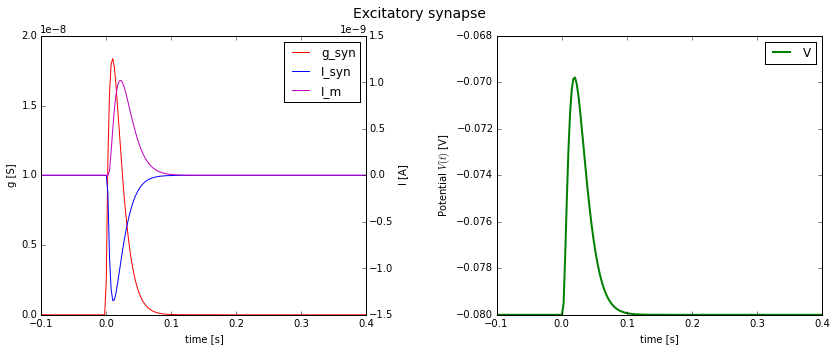

In [150]:
v, isyn, im, gsyn = synaptic_values(Eexc, tv)
plotting_v_and_depend(tv, v, isyn, im, gsyn, 'Excitatory synapse')

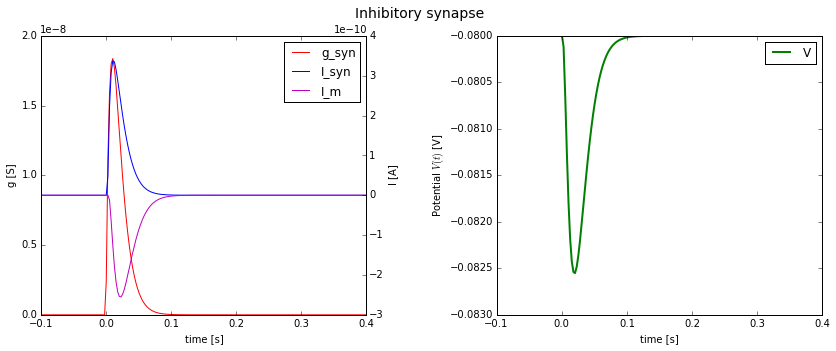

In [151]:
v, isyn, im, gsyn = synaptic_values(Einh, tv)
plotting_v_and_depend(tv, v, isyn, im, gsyn, 'Inhibitory synapse')

b)

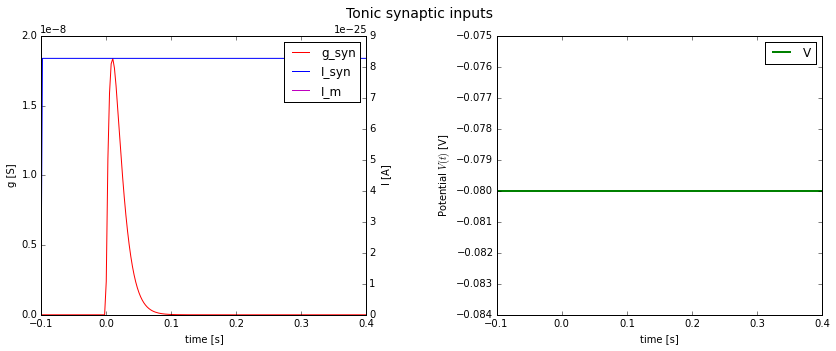

In [152]:
g_exc = 50*1e-9 #S
g_inh = 200*1e-9

v, isyn, im, gsyn = synaptic_values(Einh, tv, shunting=1)
plotting_v_and_depend(tv, v, isyn, im, gsyn, 'Tonic synaptic inputs')

As we see from the plot on the right hand side the resting potential is stable.

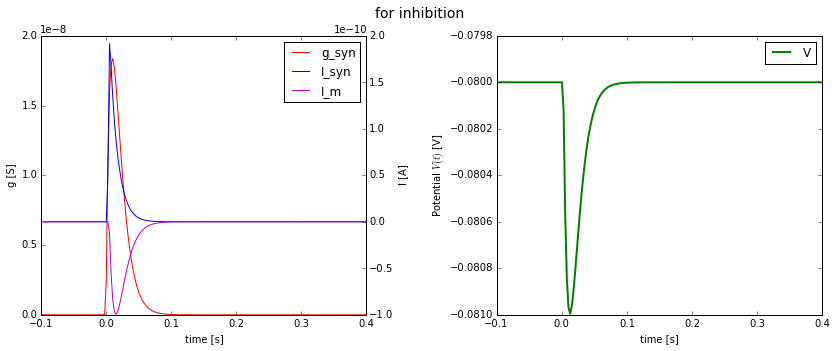

In [153]:
v, isyn, im, gsyn = synaptic_values(Einh, tv, shunting=2)
plotting_v_and_depend(tv, v, isyn, im, gsyn, 'for inhibition')

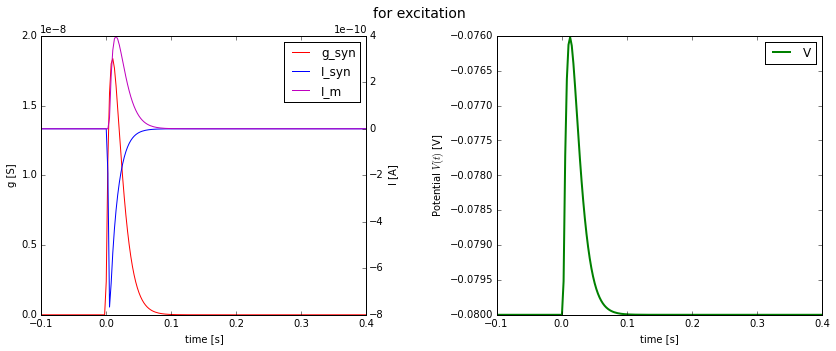

In [154]:
v, isyn, im, gsyn = synaptic_values(Eexc, tv, shunting=2)
plotting_v_and_depend(tv, v, isyn, im, gsyn, 'for excitation')

In that exercise we simulated current with synapric inputs. Comparing to the plots from point a) we can observe that resulted peak is much smaller in excitatory case. It may be due to the fact that present in that situation inhibitory inputs compensate excitatory current.

### 2. Integrate-and-fire neuron.

a)

In [155]:
def synaptic_values_lif(Esyn, tv, Vthresh, Vreset, i_e):
    dt = tv[-1]-tv[-2]
    gsyn = g_syn(tv, tau)
    v = np.zeros(len(tv))
    im = np.zeros(len(tv))
    isyn = np.zeros(len(tv))
    v[0] = Em
    v_update = 0
    for i in range(1, len(tv)):
        #print(v_update)
        v_update = v[i-1] + voltage(v[i-1], tv[i-1], isyn[i], i_e)*dt
        #pdb.set_trace()
        if v_update>= Vthresh:
            v[i] = Vreset
        else:
            v[i] = v_update
        im[i] = (v[i-1]-Em)/Rm
    return v, isyn, im, gsyn

b)

In [156]:
def plotting_v(tv, v, txt=''):
    fig, ax = plt.subplots(1,1, figsize=(7,5))
    fig.subplots_adjust(wspace=0.4)
    ln1 = ax.plot(tv, v, 'g', lw=2, label='V')
    ax.set_xlabel('time [s]')
    ax.set_ylabel('Potential $V(t)$ [V]')
    ax.legend()
    plt.suptitle(txt, fontsize=13)
    plt.show()

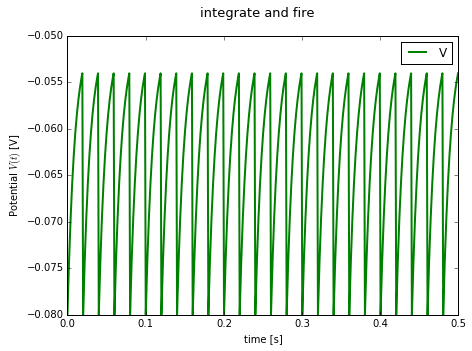

In [157]:
###################### new set of constants
tau = 10*1e-3 #s
Em = -80*1e-3 # V
Rm = 10**7 # Ohm
Ie = 0.3*1e-8
Esyn = -100*1e-3 #V
Eexc = 0
Einh = -100*1e-3 #V
v_th = -54*1e-3 #V
v_reset = Em
#######################

tv = np.linspace(0,0.5,500)
v, isyn, im, gsyn = synaptic_values_lif(Esyn, tv, v_th, v_reset, Ie)
plotting_v(tv, v, 'integrate and fire')

In [158]:
print('Firing rate: {} Hz'.format(len(np.where(np.max(v)==v)[0])*1./0.5))

Firing rate: 50.0 Hz


c)

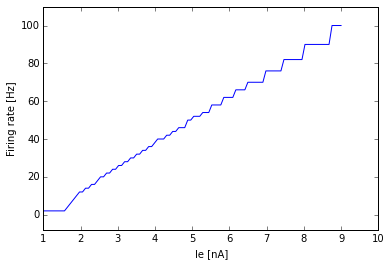

In [168]:
ie_range = np.linspace(0.1, 0.9, 100)*1e-8

frates = np.zeros(len(ie_range))

for e, ie in enumerate(ie_range):
    v, isyn, im, gsyn = synaptic_values_lif(Esyn, tv, v_th, v_reset, ie)
    frates[e] = len(np.where(np.max(v)==v)[0])*1./0.5

plt.plot(ie_range*1e9, frates)
plt.xlabel('Ie [nA]')
plt.ylabel('Firing rate [Hz]')
plt.ylim([min(frates)-10, max(frates)+10])
plt.show()

In the plot above we see that the firing rate is higher when input current increases. But dependance is not simple linear function, but rather step function with inreasing step. It's hard to find biological interpretation for such a behaviour so I assume that this is due to the simplicity of the model. Moreover we easily can see threshold value around 0.5 nA. This comes from the fact that under that threshold we do not excite our neuron enough to get action potential.

### 3. Synaptically coupled IF neurons.

a)

In [167]:
###################### changing constants for ex 3
tau = 10*1e-3 #s
Em = -70*1e-3 # V
Rm = 10**7 # Ohm
Ie = 25*1e-3/Rm # to have 25 mV
Esyn = -100*1e-3 #V
v_th = -54*1e-3 #V
v_reset = Em
#######################

In [161]:
def g_syn_temp(t, treset, tau_syn=10*1e-3, g_max=50*1e-9):
    gvec = np.zeros(len(tv))
    idcs = np.where(t>=treset)[0]
    gvec = (g_max*(t)/tau_syn)*np.exp(-(t)/tau_syn)
    gv = np.hstack((np.zeros(idcs[0]),gvec[:-idcs[0]]))
    if treset==0:
        return gvec
    return gv

def coupled_if(Esyn, Vthresh, Vreset, tv, i_e, g_max=5*1e-9, tau=tau):
    dt = tv[-1]-tv[-2]
    v_1 = np.zeros(len(tv))
    v_2 = np.zeros(len(tv))
    im = np.zeros(len(tv))
    isyn_1 = np.zeros(len(tv))
    isyn_2 = np.zeros(len(tv))
    v_1[0] = Em
    v_2[0] = Vthresh
    v1_update = 0
    v2_update = 0
    gsyn_1 = g_syn_temp(tv, 0, tau, g_max=g_max)
    gsyn_2 = g_syn_temp(tv, 0.01, tau, g_max=g_max)
    for i in range(1, len(tv)):
        isyn_1[i] = gsyn_1[i-1]*(v_1[i-1]-Esyn)
        isyn_2[i] = gsyn_2[i-1]*(v_2[i-1]-Esyn)
        v1_update = v_1[i-1] + voltage(v_1[i-1], tv[i-1], isyn_1[i], i_e)*dt
        v2_update = v_2[i-1] + voltage(v_2[i-1], tv[i-1], isyn_2[i], i_e)*dt
        if v1_update>= Vthresh:
            v_1[i] = Vreset
            gsyn_2 = g_syn_temp(tv, tv[i], tau, g_max=g_max)
        else:
            v_1[i] = v1_update
        if v2_update>= Vthresh:
            v_2[i] = Vreset
            gsyn_1 = g_syn_temp(tv, tv[i], tau, g_max=g_max)
        else:
            v_2[i] = v2_update
    return v_1, v_2

def plotting_v(tv, v1, v2, txt=''):
    fig, ax = plt.subplots(1,1, figsize=(7,5))
    fig.subplots_adjust(wspace=0.4)
    ln1 = ax.plot(tv, v1, 'g', label='$V_1$')
    ln2 = ax.plot(tv, v2, 'm', label='$V_2$')
    ax.set_xlabel('time [s]')
    ax.set_ylabel('Potential $V(t)$ [V]')
    ax.legend()
    plt.suptitle(txt, fontsize=13)
    plt.show()

b)

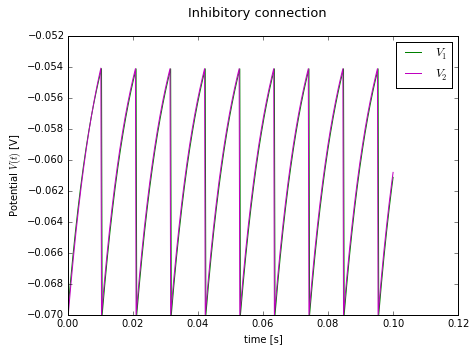

In [162]:
tv = np.linspace(0,0.1,500)
v1, v2 = coupled_if(Esyn, v_th, v_reset, tv, Ie)
plotting_v(tv, v1, v2, "Inhibitory connection")

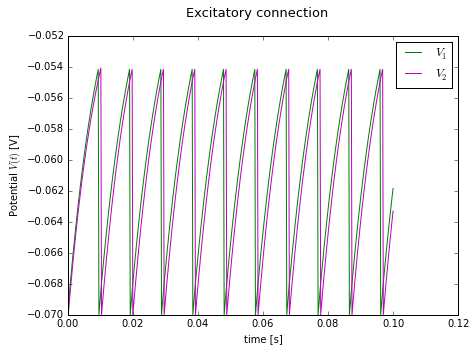

In [163]:
tv = np.linspace(0,0.1,500)
v1, v2 = coupled_if(0, v_th, v_reset, tv, Ie)
plotting_v(tv, v1, v2, "Excitatory connection")

In case of inhibitory connection between neurons they imediatly synchronize their firings, but excitatory neurons still preserve initial difference in phase of oscillations.

c)

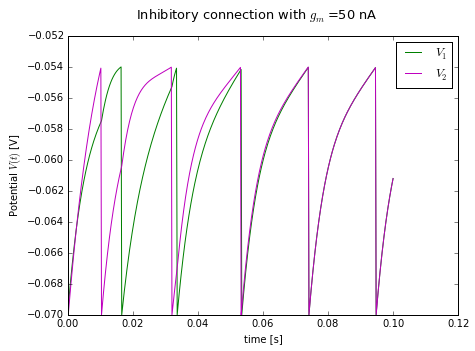

In [164]:
v1, v2 = coupled_if(Esyn, v_th, v_reset, tv, Ie, g_max=50*1e-9)
plotting_v(tv, v1, v2, r"Inhibitory connection with $g_m$={} nA".format(50))

In the plot above I increased $g_{max}$ to 50 nA. We can observe that now two things. First is increasing of period of oscilation which is basic illation of equetion (2) from exercises sheet. More intresting is second feature of the plot. We see that now synchronization of neurons firing is much slower.

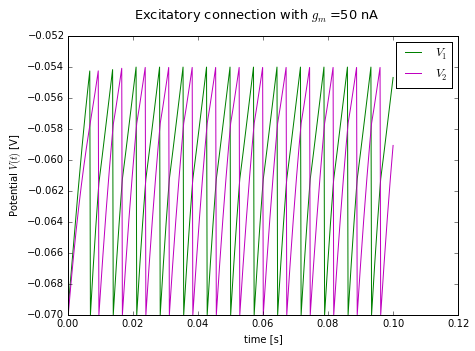

In [165]:
v1, v2 = coupled_if(0, v_th, v_reset, tv, Ie, g_max=50*1e-9)
plotting_v(tv, v1, v2, r"Excitatory connection with $g_m$={} nA".format(50))

In terms of excitatory synapses we see enhancement of desynchronization effect.

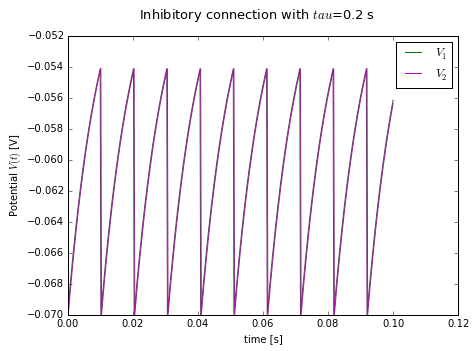

In [166]:
tau_new = 200*1e-3 
v1, v2 = coupled_if(Esyn, v_th, v_reset, tv, Ie, g_max=5*1e-9, tau=tau_new)
plotting_v(tv, v1, v2, r"Inhibitory connection with $tau$={} s".format(tau_new))

In terms of $\tau_{syn}$ I tested different values from range 0.02 to 200 ms and I didn;t observe any spectacular difference which is a bit counterintuitive for me. Above one of the attempts.